In [1]:
from tardis import run_tardis
from tardis.visualization import SDECPlotter

from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
joj1 = np.loadtxt("../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii")
joj2 = np.loadtxt("../spectroscopy/data/ZTF22aajijjf_20220526_SEDM_1.txt")
from scipy.integrate import trapz

flux1 = trapz(joj1[:, 1], joj1[:, 0])
flux2 = trapz(joj2[:, 1], joj2[:, 0])
DL = (114.48 * u.Mpc).cgs.value
luminosity1 = (flux1 * 4 * np.pi * DL**2) / (1 * u.Lsun).cgs.value
luminosity2 = (flux2 * 4 * np.pi * DL**2) / (1 * u.Lsun).cgs.value
z = 0.02736
print('First spec:')
print('wv_min = {:.2f}, wv_max = {:.2f}'.format(joj1[0, 0]/(1+z), joj1[-1, 0]/(1+z)))
print('log L = {:.2f} log Lsun'.format(np.log10(luminosity1)))

print('Second spec:')
print('wv_min = {:.2f}, wv_max = {:.2f}'.format(joj2[0, 0]/(1+z), joj2[-1, 0]/(1+z)))
print('log L = {:.2f} log Lsun'.format(np.log10(luminosity2)))

First spec:
wv_min = 3407.22, wv_max = 9734.75
log L = 8.52 log Lsun
Second spec:
wv_min = 3676.12, wv_max = 8977.67
log L = 9.40 log Lsun


In [3]:
# from tardis.io.atom_data.util import download_atom_data
# download_atom_data('kurucz_cd23_chianti_H_He')

In [4]:
iso_title = np.array('H1  He4 C12  N14  O16  Ne20  Na23  Mg24  Al27  Si28  S32   Ar36  Ca40  Sc45  Ti48  V51   Cr52  Mn55  Fe56  Co59  Ni58  Ni56  Co56  Fe52  Cr48  V48   Mn52'.split())

In [5]:
# from wikipedia
tau_Ni56 = 6.077 / np.log(2)  # Ni-56 --> Co-56
tau_Co56 = 77.233 / np.log(2)  # Co-56 --> Fe-56

tau_Fe52 = 8.275 / 24 / np.log(2)  # Fe-52 --> Mn-52
tau_Mn52 = 21.1 / 60 / 24 / np.log(2)  # Mn-52 --> Cr-52

tau_Cr48 = 21.56 / 24 / np.log(2)  # Cr-48 --> V-48
tau_V48 = 15.9735 / np.log(2)  # V-48 --> Ti-48

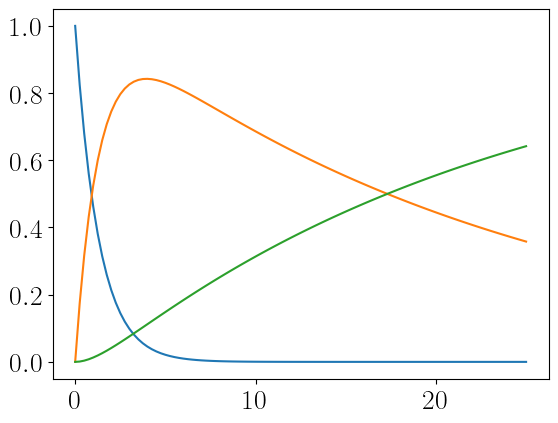

In [6]:
# radioactive decay
from scipy.integrate import odeint

time = np.linspace(0, 25, 101)


def decay_chain(tau1, tau2, n1, n2, n3, time):
    def deriv(A, t, Ab):
        return np.dot(Ab, A)

    Ab = np.array([[-1 / tau1,        0,  0], 
                   [1 / tau1, -1 / tau2,  0], 
                   [0,         1 / tau2,  0]])

    A0 = np.array([n1, n2, n3])

    MA = odeint(deriv, A0, time, args=(Ab,))
    MA = np.where(MA > 0, MA, 0)
    return MA


plt.plot(time, decay_chain(tau_Cr48, tau_V48, 1, 0, 0, time))


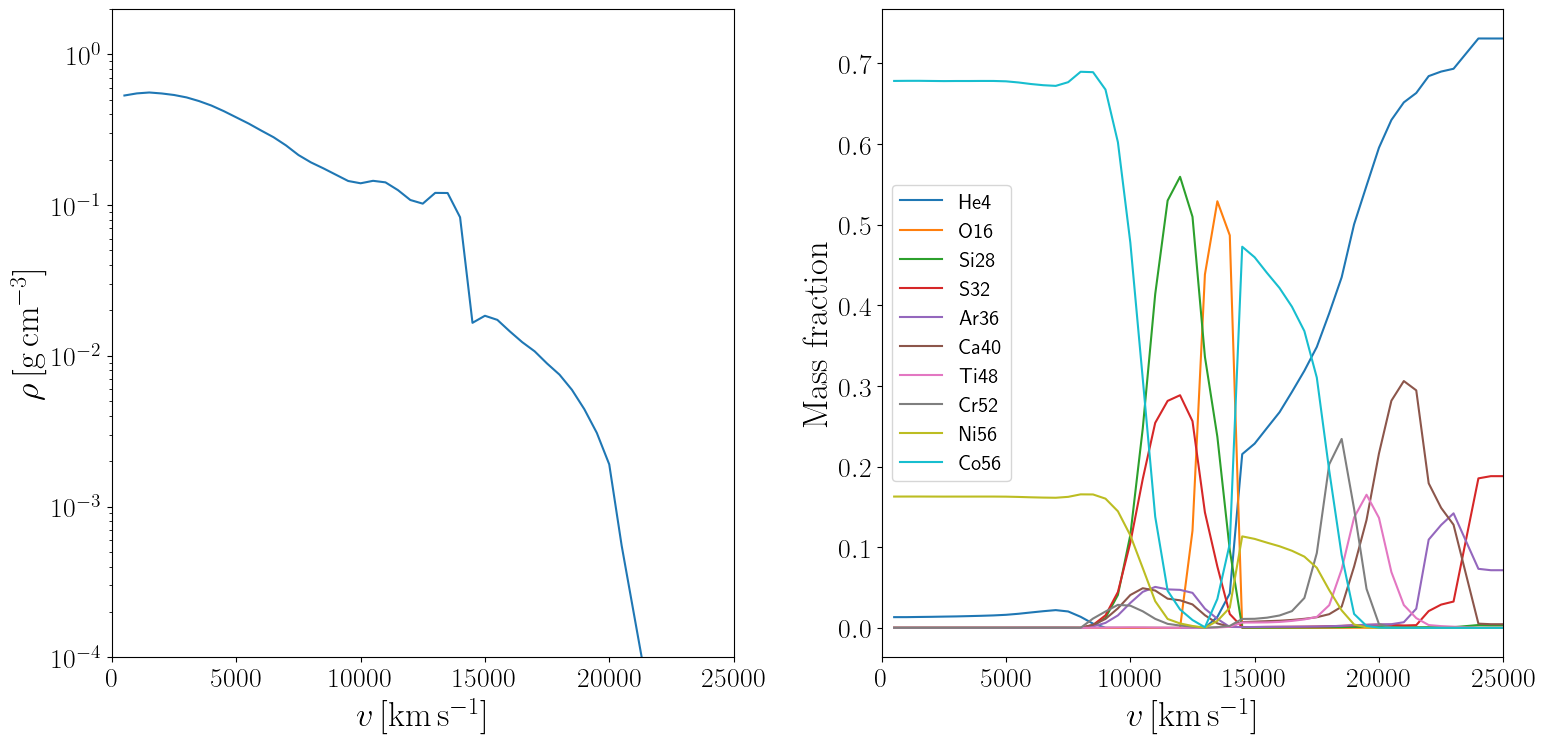

In [7]:
with open("./Shen+2021/d14e5_m100_wedge_mu_00.txt", "r") as f:
    lines = [l for l in f.readlines() if l[0] != "!"]
prof = []
for l in lines[3:]:
    prof.append(np.array(l.split(), dtype=float))
# dat = np.loadtxt('./doubledet_2021_m1003_1_isotopes.dat')
prof = np.array(prof)
prof[:, 0] = prof[:, 0] / 1e5  # cm/s --> km/s
iso_dat = prof[:, 3:].copy()
iso_dat0 = prof[:, 3:].copy()

# Ni56 --> Co56 --> Fe56
idx1 = np.argwhere(iso_title == "Ni56").ravel()[0]
idx2 = np.argwhere(iso_title == "Co56").ravel()[0]
idx3 = np.argwhere(iso_title == "Fe56").ravel()[0]

t_post_exp = 15
for k in range(len(prof)):
    iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
        tau_Ni56,
        tau_Co56,
        iso_dat[k, idx1],
        iso_dat[k, idx2],
        iso_dat[k, idx3],
        np.array([0, t_post_exp]),
    )[-1]

# Fe52 --> Mn52 --> Cr52
idx1 = np.argwhere(iso_title == "Fe52").ravel()[0]
idx2 = np.argwhere(iso_title == "Mn52").ravel()[0]
idx3 = np.argwhere(iso_title == "Cr52").ravel()[0]
for k in range(len(prof)):
    iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
        tau_Fe52,
        tau_Mn52,
        iso_dat[k, idx1],
        iso_dat[k, idx2],
        iso_dat[k, idx3],
        np.array([0, t_post_exp]),
    )[-1]

# Cr48 --> V48 --> Ti48
idx1 = np.argwhere(iso_title == "Cr48").ravel()[0]
idx2 = np.argwhere(iso_title == "V48").ravel()[0]
idx3 = np.argwhere(iso_title == "Ti48").ravel()[0]
for k in range(len(prof)):
    iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
        tau_Cr48,
        tau_V48,
        iso_dat[k, idx1],
        iso_dat[k, idx2],
        iso_dat[k, idx3],
        np.array([0, t_post_exp]),
    )[-1]

idx = np.max(iso_dat, axis=0) > 1e-1
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
ax[0].plot(prof[:, 0], prof[:, 1])
ax[0].set_yscale("log")
ax[1].plot(prof[:, 0], iso_dat[:, idx], label=iso_title[idx])
ax[1].legend(prop={"size": 15})
ax[0].set_ylim(1e-4, 2)
ax[1].set_xlim(0, 25000)
ax[0].set_xlabel(r"$v\,[\mathrm{km}\,\mathrm{s}^{-1}]$")
ax[1].set_xlabel(r"$v\,[\mathrm{km}\,\mathrm{s}^{-1}]$")
ax[0].set_ylabel(r"$\rho\,[\mathrm{g}\,\mathrm{cm}^{-3}]$")
ax[1].set_ylabel(r"$\mathrm{Mass\ fraction}$")
fig.tight_layout()

profile = np.append(prof[:, :2], iso_dat0, axis=1)

In [8]:
def write_CSVY(fname, isotopes, profile, time=0, vmin=8000, vmax=28000):
    lines = '''---
name: csvy_full
model_density_time_0: 0.0012 day
model_isotope_time_0: 0.0012 day
description: Example csvy config file for TARDIS.
tardis_model_config_version: v1.0
datatype:
  fields:
    -  name: velocity
       unit: km/s
       desc: velocities of shell outer bounderies.
    -  name: density
       unit: g/cm^3
       desc: density of shell.'''
    lines = [l + '\n' for l in lines.split('\n')]
    for i in isotopes:
        lines.append('    -  name: {}\n'.format(i))
        lines.append('       desc: fractional {} abundance.\n'.format(i))
    lines.append('---\n')
    lines.append(','.join(np.append('velocity,density', isotopes)) + '\n')

    iso_dat = profile[:, 2:].copy()

    # Ni56 --> Co56 --> Fe56
    idx1 = np.argwhere(isotopes == "Ni56").ravel()[0]
    idx2 = np.argwhere(isotopes == "Co56").ravel()[0]
    idx3 = np.argwhere(isotopes == "Fe56").ravel()[0]
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Ni56,
            tau_Co56,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, time]),
        )[-1]

    # Fe52 --> Mn52 --> Cr52
    idx1 = np.argwhere(isotopes == "Fe52").ravel()[0]
    idx2 = np.argwhere(isotopes == "Mn52").ravel()[0]
    idx3 = np.argwhere(isotopes == "Cr52").ravel()[0]
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Fe52,
            tau_Mn52,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, time]),
        )[-1]

    # Cr48 --> V48 --> Ti48
    idx1 = np.argwhere(isotopes == "Cr48").ravel()[0]
    idx2 = np.argwhere(isotopes == "V48").ravel()[0]
    idx3 = np.argwhere(isotopes == "Ti48").ravel()[0]
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Cr48,
            tau_V48,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, time]),
        )[-1]

    profile = np.append(profile[:, :2], iso_dat, axis=1)
    
    for d in profile:
        if d[0] < vmin or d[0] > vmax:
            continue
        lines.append(','.join(['{:.5e}'.format(val) for val in d]) + '\n')

    with open(fname, 'w') as f:
        f.writelines(lines)

def write_config(fname, log_L, time, csvy_model):
    hdr = '''# Example YAML configuration for TARDIS
tardis_config_version: v1.0\n'''

    model = '''supernova:
  luminosity_requested: {:.2f} log_lsun
  time_explosion: {:.2f} day
  luminosity_wavelength_start: 3000 angstrom
  luminosity_wavelength_end: 9500 angstrom
atom_data: kurucz_cd23_chianti_H_He.h5

csvy_model: {}\n'''.format(log_L, time, csvy_model)

    simulation = '''plasma:
  disable_electron_scattering: no
  ionization: lte
  excitation: lte
  radiative_rates_type: dilute-blackbody
  line_interaction_type: macroatom

montecarlo:
  seed: 23111963
  no_of_packets: 4.0e+4
  iterations: 40
  nthreads: 1

  last_no_of_packets: 1.e+5
  no_of_virtual_packets: 10

  convergence_strategy:
    type: damped
    damping_constant: 1.0
    threshold: 0.05
    fraction: 0.8
    hold_iterations: 3
    t_inner:
      damping_constant: 0.1

spectrum:
  start: 500 angstrom
  stop: 20000 angstrom
  num: 10000'''
    
    with open(fname, 'w') as f:
        f.writelines(hdr + model + simulation)

In [9]:
with open('./Shen+2021/d14e5_mu_0_spec.txt') as f:
    l = f.readline()
    time = float(l.split('=')[-1])
    l = f.readline()
    log_L = float(l.split('=')[-1])
write_CSVY('./d14e5_mu00', isotopes=iso_title, profile=profile, time=time, vmin=10000)
write_config(fname='tardis_+2.yml', log_L=log_L-0.32, time=time, csvy_model='d14e5_mu00')
sim = run_tardis("tardis_+2.yml",
                 virtual_packet_logging=True,
                 show_convergence_plots=True,
                 export_convergence_plots=True,
                 log_level="INFO")
plotter = SDECPlotter.from_simulation(sim)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 40 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.780e+42 erg / s
	Luminosity absorbed  = 2.040e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.76e+03,8.16e+03,0.39,0.529
5,7.7e+03,7.69e+03,0.19,0.239
10,7.63e+03,7.03e+03,0.123,0.128
15,7.57e+03,6.25e+03,0.0869,0.117
20,7.51e+03,5.35e+03,0.0652,0.136
25,7.45e+03,5.24e+03,0.0509,0.111
30,7.39e+03,5.17e+03,0.0409,0.0924
35,7.33e+03,5.1e+03,0.0336,0.0783


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7767.525 K
	Expected t_inner for next iteration = 8347.711 K
 (base.py:554)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


    'data': [{'type': 'scatter', 'uid': 'c9bcac86-2af6-4684-a1b0-4ebebfe5669e', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.021e+42 erg / s
	Luminosity absorbed  = 2.855e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.16e+03,8.63e+03,0.529,0.585
5,7.69e+03,8.09e+03,0.239,0.301
10,7.03e+03,7.81e+03,0.128,0.175
15,6.25e+03,7.13e+03,0.117,0.15
20,5.35e+03,5.12e+03,0.136,0.211
25,5.24e+03,4.82e+03,0.111,0.188
30,5.17e+03,4.74e+03,0.0924,0.155
35,5.1e+03,4.68e+03,0.0783,0.131


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8347.711 K
	Expected t_inner for next iteration = 8881.683 K
 (base.py:554)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning:

invalid value encountered in true_divide

 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.919e+42 erg / s
	Luminosity absorbed  = 3.350e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.63e+03,9.19e+03,0.585,0.58
5,8.09e+03,8.31e+03,0.301,0.312
10,7.81e+03,8.27e+03,0.175,0.15
15,7.13e+03,8e+03,0.15,0.118
20,5.12e+03,5.93e+03,0.211,0.166
25,4.82e+03,5.37e+03,0.188,0.162
30,4.74e+03,5.27e+03,0.155,0.135
35,4.68e+03,5.2e+03,0.131,0.114


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8881.683 K
	Expected t_inner for next iteration = 9205.104 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.664e+42 erg / s
	Luminosity absorbed  = 3.486e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.19e+03,9.64e+03,0.58,0.548
5,8.31e+03,8.43e+03,0.312,0.311
10,8.27e+03,7.87e+03,0.15,0.159
15,8e+03,7.37e+03,0.118,0.127
20,5.93e+03,6.24e+03,0.166,0.148
25,5.37e+03,5.88e+03,0.162,0.134
30,5.27e+03,5.78e+03,0.135,0.112
35,5.2e+03,5.71e+03,0.114,0.0948


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9205.104 K
	Expected t_inner for next iteration = 9405.473 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.917e+42 erg / s
	Luminosity absorbed  = 3.730e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.64e+03,9.99e+03,0.548,0.53
5,8.43e+03,8.76e+03,0.311,0.313
10,7.87e+03,8.45e+03,0.159,0.154
15,7.37e+03,7.82e+03,0.127,0.124
20,6.24e+03,6.11e+03,0.148,0.169
25,5.88e+03,5.88e+03,0.134,0.143
30,5.78e+03,5.78e+03,0.112,0.119
35,5.71e+03,5.71e+03,0.0948,0.101


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9405.473 K
	Expected t_inner for next iteration = 9572.553 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.355e+42 erg / s
	Luminosity absorbed  = 3.689e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.99e+03,1.02e+04,0.53,0.515
5,8.76e+03,9.02e+03,0.313,0.29
10,8.45e+03,8.74e+03,0.154,0.141
15,7.82e+03,8.37e+03,0.124,0.108
20,6.11e+03,6.36e+03,0.169,0.16
25,5.88e+03,6.06e+03,0.143,0.139
30,5.78e+03,5.96e+03,0.119,0.116
35,5.71e+03,5.88e+03,0.101,0.0983


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9572.553 K
	Expected t_inner for next iteration = 9684.392 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.669e+42 erg / s
	Luminosity absorbed  = 3.736e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.02e+04,1.04e+04,0.515,0.5
5,9.02e+03,9.32e+03,0.29,0.271
10,8.74e+03,8.86e+03,0.141,0.137
15,8.37e+03,8.36e+03,0.108,0.104
20,6.36e+03,6.59e+03,0.16,0.146
25,6.06e+03,6.32e+03,0.139,0.126
30,5.96e+03,6.22e+03,0.116,0.105
35,5.88e+03,6.14e+03,0.0983,0.0887


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9684.392 K
	Expected t_inner for next iteration = 9760.598 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.841e+42 erg / s
	Luminosity absorbed  = 3.730e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.04e+04,1.05e+04,0.5,0.495
5,9.32e+03,9.56e+03,0.271,0.256
10,8.86e+03,9.23e+03,0.137,0.128
15,8.36e+03,8.61e+03,0.104,0.101
20,6.59e+03,6.65e+03,0.146,0.145
25,6.32e+03,6.4e+03,0.126,0.124
30,6.22e+03,6.3e+03,0.105,0.103
35,6.14e+03,6.21e+03,0.0887,0.0875


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9760.598 K
	Expected t_inner for next iteration = 9818.492 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.987e+42 erg / s
	Luminosity absorbed  = 3.780e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.05e+04,1.06e+04,0.495,0.485
5,9.56e+03,9.81e+03,0.256,0.24
10,9.23e+03,9.54e+03,0.128,0.118
15,8.61e+03,8.77e+03,0.101,0.0965
20,6.65e+03,6.84e+03,0.145,0.134
25,6.4e+03,6.58e+03,0.124,0.114
30,6.3e+03,6.48e+03,0.103,0.0946
35,6.21e+03,6.39e+03,0.0875,0.0802


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9818.492 K
	Expected t_inner for next iteration = 9861.466 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.137e+42 erg / s
	Luminosity absorbed  = 3.726e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.06e+04,1.07e+04,0.485,0.485
5,9.81e+03,9.91e+03,0.24,0.234
10,9.54e+03,9.53e+03,0.118,0.121
15,8.77e+03,8.8e+03,0.0965,0.0954
20,6.84e+03,6.92e+03,0.134,0.131
25,6.58e+03,6.67e+03,0.114,0.111
30,6.48e+03,6.57e+03,0.0946,0.0925
35,6.39e+03,6.48e+03,0.0802,0.0784


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9861.466 K
	Expected t_inner for next iteration = 9889.478 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.181e+42 erg / s
	Luminosity absorbed  = 3.745e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.07e+04,1.07e+04,0.485,0.479
5,9.91e+03,1e+04,0.234,0.226
10,9.53e+03,9.63e+03,0.121,0.119
15,8.8e+03,8.9e+03,0.0954,0.0941
20,6.92e+03,6.95e+03,0.131,0.131
25,6.67e+03,6.69e+03,0.111,0.111
30,6.57e+03,6.58e+03,0.0925,0.0926
35,6.48e+03,6.5e+03,0.0784,0.0785


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9889.478 K
	Expected t_inner for next iteration = 9913.204 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.200e+42 erg / s
	Luminosity absorbed  = 3.751e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.07e+04,1.08e+04,0.479,0.468
5,1e+04,1.02e+04,0.226,0.218
10,9.63e+03,9.73e+03,0.119,0.115
15,8.9e+03,8.95e+03,0.0941,0.0921
20,6.95e+03,6.97e+03,0.131,0.128
25,6.69e+03,6.74e+03,0.111,0.108
30,6.58e+03,6.63e+03,0.0926,0.0896
35,6.5e+03,6.55e+03,0.0785,0.0759


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9913.204 K
	Expected t_inner for next iteration = 9935.135 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.334e+42 erg / s
	Luminosity absorbed  = 3.682e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04,1.08e+04,0.468,0.469
5,1.02e+04,1.03e+04,0.218,0.21
10,9.73e+03,9.74e+03,0.115,0.116
15,8.95e+03,8.94e+03,0.0921,0.0939
20,6.97e+03,7.02e+03,0.128,0.129
25,6.74e+03,6.77e+03,0.108,0.109
30,6.63e+03,6.67e+03,0.0896,0.0903
35,6.55e+03,6.58e+03,0.0759,0.0765


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9935.135 K
	Expected t_inner for next iteration = 9944.264 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.312e+42 erg / s
	Luminosity absorbed  = 3.726e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04,1.08e+04,0.469,0.471
5,1.03e+04,1.04e+04,0.21,0.204
10,9.74e+03,9.93e+03,0.116,0.11
15,8.94e+03,9.02e+03,0.0939,0.0919
20,7.02e+03,7.05e+03,0.129,0.127
25,6.77e+03,6.79e+03,0.109,0.108
30,6.67e+03,6.68e+03,0.0903,0.0899
35,6.58e+03,6.59e+03,0.0765,0.0763


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9944.264 K
	Expected t_inner for next iteration = 9955.469 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.335e+42 erg / s
	Luminosity absorbed  = 3.781e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04,1.08e+04,0.471,0.479
5,1.04e+04,1.04e+04,0.204,0.208
10,9.93e+03,9.89e+03,0.11,0.112
15,9.02e+03,9.01e+03,0.0919,0.0915
20,7.05e+03,7.01e+03,0.127,0.128
25,6.79e+03,6.78e+03,0.108,0.108
30,6.68e+03,6.68e+03,0.0899,0.0894
35,6.59e+03,6.59e+03,0.0763,0.0757


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9955.469 K
	Expected t_inner for next iteration = 9964.555 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.356e+42 erg / s
	Luminosity absorbed  = 3.747e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04,1.09e+04,0.479,0.467
5,1.04e+04,1.05e+04,0.208,0.201
10,9.89e+03,9.98e+03,0.112,0.108
15,9.01e+03,9.03e+03,0.0915,0.0917
20,7.01e+03,7.06e+03,0.128,0.126
25,6.78e+03,6.81e+03,0.108,0.107
30,6.68e+03,6.7e+03,0.0894,0.0886
35,6.59e+03,6.62e+03,0.0757,0.0751


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9964.555 K
	Expected t_inner for next iteration = 9971.671 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.317e+42 erg / s
	Luminosity absorbed  = 3.739e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.09e+04,0.467,0.463
5,1.05e+04,1.06e+04,0.201,0.193
10,9.98e+03,9.79e+03,0.108,0.113
15,9.03e+03,9.09e+03,0.0917,0.0892
20,7.06e+03,7.06e+03,0.126,0.126
25,6.81e+03,6.82e+03,0.107,0.106
30,6.7e+03,6.71e+03,0.0886,0.088
35,6.62e+03,6.63e+03,0.0751,0.0746


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9971.671 K
	Expected t_inner for next iteration = 9982.434 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.429e+42 erg / s
	Luminosity absorbed  = 3.728e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.09e+04,0.463,0.463
5,1.06e+04,1.06e+04,0.193,0.194
10,9.79e+03,9.85e+03,0.113,0.114
15,9.09e+03,9.1e+03,0.0892,0.0911
20,7.06e+03,7.07e+03,0.126,0.127
25,6.82e+03,6.82e+03,0.106,0.107
30,6.71e+03,6.72e+03,0.088,0.0893
35,6.63e+03,6.63e+03,0.0746,0.0757


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9982.434 K
	Expected t_inner for next iteration = 9982.786 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.372e+42 erg / s
	Luminosity absorbed  = 3.705e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.09e+04,0.463,0.469
5,1.06e+04,1.06e+04,0.194,0.199
10,9.85e+03,9.91e+03,0.114,0.111
15,9.1e+03,9.01e+03,0.0911,0.0928
20,7.07e+03,7.09e+03,0.127,0.126
25,6.82e+03,6.83e+03,0.107,0.106
30,6.72e+03,6.73e+03,0.0893,0.0883
35,6.63e+03,6.64e+03,0.0757,0.0748


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9982.786 K
	Expected t_inner for next iteration = 9988.422 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.402e+42 erg / s
	Luminosity absorbed  = 3.764e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.09e+04,0.469,0.472
5,1.06e+04,1.05e+04,0.199,0.2
10,9.91e+03,9.96e+03,0.111,0.111
15,9.01e+03,9.05e+03,0.0928,0.0921
20,7.09e+03,7.06e+03,0.126,0.128
25,6.83e+03,6.83e+03,0.106,0.107
30,6.73e+03,6.72e+03,0.0883,0.0894
35,6.64e+03,6.63e+03,0.0748,0.0757


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9988.422 K
	Expected t_inner for next iteration = 9991.203 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 21 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.431e+42 erg / s
	Luminosity absorbed  = 3.724e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.09e+04,0.472,0.46
5,1.05e+04,1.06e+04,0.2,0.197
10,9.96e+03,1e+04,0.111,0.108
15,9.05e+03,9.1e+03,0.0921,0.0905
20,7.06e+03,7.1e+03,0.128,0.125
25,6.83e+03,6.86e+03,0.107,0.105
30,6.72e+03,6.76e+03,0.0894,0.0874
35,6.63e+03,6.67e+03,0.0757,0.074


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9991.203 K
	Expected t_inner for next iteration = 9991.353 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 22 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.471e+42 erg / s
	Luminosity absorbed  = 3.694e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.09e+04,0.46,0.46
5,1.06e+04,1.06e+04,0.197,0.2
10,1e+04,1e+04,0.108,0.11
15,9.1e+03,9.09e+03,0.0905,0.0913
20,7.1e+03,7.08e+03,0.125,0.127
25,6.86e+03,6.85e+03,0.105,0.107
30,6.76e+03,6.74e+03,0.0874,0.0885
35,6.67e+03,6.66e+03,0.074,0.075


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9991.353 K
	Expected t_inner for next iteration = 9987.847 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 23 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.389e+42 erg / s
	Luminosity absorbed  = 3.714e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.09e+04,0.46,0.469
5,1.06e+04,1.06e+04,0.2,0.196
10,1e+04,1.01e+04,0.11,0.108
15,9.09e+03,9.12e+03,0.0913,0.0901
20,7.08e+03,7.12e+03,0.127,0.123
25,6.85e+03,6.87e+03,0.107,0.104
30,6.74e+03,6.76e+03,0.0885,0.0866
35,6.66e+03,6.67e+03,0.075,0.0734


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9987.847 K
	Expected t_inner for next iteration = 9991.897 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 24 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.452e+42 erg / s
	Luminosity absorbed  = 3.703e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 15/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.1e+04,0.469,0.46
5,1.06e+04,1.08e+04,0.196,0.19
10,1.01e+04,1.01e+04,0.108,0.109
15,9.12e+03,9.05e+03,0.0901,0.0927
20,7.12e+03,7.13e+03,0.123,0.125
25,6.87e+03,6.85e+03,0.104,0.107
30,6.76e+03,6.75e+03,0.0866,0.0886
35,6.67e+03,6.66e+03,0.0734,0.0751


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9991.897 K
	Expected t_inner for next iteration = 9990.081 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 25 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.397e+42 erg / s
	Luminosity absorbed  = 3.674e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 16/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.46,0.446
5,1.08e+04,1.07e+04,0.19,0.193
10,1.01e+04,1.01e+04,0.109,0.105
15,9.05e+03,9.08e+03,0.0927,0.0914
20,7.13e+03,7.09e+03,0.125,0.125
25,6.85e+03,6.85e+03,0.107,0.106
30,6.75e+03,6.74e+03,0.0886,0.0877
35,6.66e+03,6.65e+03,0.0751,0.0743


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9990.081 K
	Expected t_inner for next iteration = 9993.341 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 26 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.495e+42 erg / s
	Luminosity absorbed  = 3.693e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 17/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.446,0.453
5,1.07e+04,1.06e+04,0.193,0.198
10,1.01e+04,1e+04,0.105,0.11
15,9.08e+03,9.15e+03,0.0914,0.0909
20,7.09e+03,7.1e+03,0.125,0.127
25,6.85e+03,6.85e+03,0.106,0.107
30,6.74e+03,6.74e+03,0.0877,0.0893
35,6.65e+03,6.65e+03,0.0743,0.0757


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9993.341 K
	Expected t_inner for next iteration = 9987.628 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 27 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.408e+42 erg / s
	Luminosity absorbed  = 3.669e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 18/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.453,0.454
5,1.06e+04,1.06e+04,0.198,0.193
10,1e+04,1e+04,0.11,0.109
15,9.15e+03,9.09e+03,0.0909,0.0905
20,7.1e+03,7.11e+03,0.127,0.124
25,6.85e+03,6.87e+03,0.107,0.105
30,6.74e+03,6.76e+03,0.0893,0.0873
35,6.65e+03,6.67e+03,0.0757,0.0741


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9987.628 K
	Expected t_inner for next iteration = 9989.893 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 28 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.459e+42 erg / s
	Luminosity absorbed  = 3.672e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 19/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.09e+04,0.454,0.463
5,1.06e+04,1.06e+04,0.193,0.197
10,1e+04,1e+04,0.109,0.111
15,9.09e+03,9.13e+03,0.0905,0.0912
20,7.11e+03,7.09e+03,0.124,0.127
25,6.87e+03,6.84e+03,0.105,0.107
30,6.76e+03,6.73e+03,0.0873,0.0893
35,6.67e+03,6.65e+03,0.0741,0.0757


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9989.893 K
	Expected t_inner for next iteration = 9987.483 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 29 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.451e+42 erg / s
	Luminosity absorbed  = 3.727e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 20/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.09e+04,0.463,0.465
5,1.06e+04,1.07e+04,0.197,0.198
10,1e+04,1e+04,0.111,0.109
15,9.13e+03,9.11e+03,0.0912,0.0912
20,7.09e+03,7.08e+03,0.127,0.127
25,6.84e+03,6.83e+03,0.107,0.108
30,6.73e+03,6.73e+03,0.0893,0.0894
35,6.65e+03,6.64e+03,0.0757,0.0757


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9987.483 K
	Expected t_inner for next iteration = 9985.760 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 30 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.347e+42 erg / s
	Luminosity absorbed  = 3.786e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 21/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.1e+04,0.465,0.457
5,1.07e+04,1.06e+04,0.198,0.196
10,1e+04,1.01e+04,0.109,0.105
15,9.11e+03,9.15e+03,0.0912,0.088
20,7.08e+03,7.09e+03,0.127,0.124
25,6.83e+03,6.84e+03,0.108,0.105
30,6.73e+03,6.73e+03,0.0894,0.0871
35,6.64e+03,6.65e+03,0.0757,0.0738


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9985.760 K
	Expected t_inner for next iteration = 9993.709 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 31 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.411e+42 erg / s
	Luminosity absorbed  = 3.741e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 22/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.457,0.46
5,1.06e+04,1.06e+04,0.196,0.198
10,1.01e+04,1e+04,0.105,0.11
15,9.15e+03,9.11e+03,0.088,0.0899
20,7.09e+03,7.11e+03,0.124,0.125
25,6.84e+03,6.85e+03,0.105,0.106
30,6.73e+03,6.74e+03,0.0871,0.0882
35,6.65e+03,6.65e+03,0.0738,0.0748


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9993.709 K
	Expected t_inner for next iteration = 9995.719 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 32 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.464e+42 erg / s
	Luminosity absorbed  = 3.761e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 23/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.46,0.458
5,1.06e+04,1.06e+04,0.198,0.197
10,1e+04,9.99e+03,0.11,0.109
15,9.11e+03,9e+03,0.0899,0.0937
20,7.11e+03,7.1e+03,0.125,0.125
25,6.85e+03,6.85e+03,0.106,0.106
30,6.74e+03,6.74e+03,0.0882,0.0882
35,6.65e+03,6.66e+03,0.0748,0.0748


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9995.719 K
	Expected t_inner for next iteration = 9992.876 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 33 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.436e+42 erg / s
	Luminosity absorbed  = 3.717e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 24/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.09e+04,0.458,0.464
5,1.06e+04,1.07e+04,0.197,0.194
10,9.99e+03,1.01e+04,0.109,0.106
15,9e+03,8.98e+03,0.0937,0.0947
20,7.1e+03,7.04e+03,0.125,0.129
25,6.85e+03,6.81e+03,0.106,0.109
30,6.74e+03,6.7e+03,0.0882,0.0902
35,6.66e+03,6.61e+03,0.0748,0.0764


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9992.876 K
	Expected t_inner for next iteration = 9992.557 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 34 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.467e+42 erg / s
	Luminosity absorbed  = 3.743e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 25/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.1e+04,0.464,0.459
5,1.07e+04,1.07e+04,0.194,0.193
10,1.01e+04,1.02e+04,0.106,0.105
15,8.98e+03,9.16e+03,0.0947,0.0907
20,7.04e+03,7.1e+03,0.129,0.126
25,6.81e+03,6.87e+03,0.109,0.105
30,6.7e+03,6.76e+03,0.0902,0.0875
35,6.61e+03,6.67e+03,0.0764,0.0741


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9992.557 K
	Expected t_inner for next iteration = 9989.370 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 35 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.387e+42 erg / s
	Luminosity absorbed  = 3.696e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 26/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.459,0.459
5,1.07e+04,1.08e+04,0.193,0.189
10,1.02e+04,1.02e+04,0.105,0.104
15,9.16e+03,9.19e+03,0.0907,0.0886
20,7.1e+03,7.09e+03,0.126,0.126
25,6.87e+03,6.84e+03,0.105,0.106
30,6.76e+03,6.74e+03,0.0875,0.0883
35,6.67e+03,6.65e+03,0.0741,0.0749


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9989.370 K
	Expected t_inner for next iteration = 9993.633 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 36 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.502e+42 erg / s
	Luminosity absorbed  = 3.660e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 27/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.09e+04,0.459,0.46
5,1.08e+04,1.08e+04,0.189,0.193
10,1.02e+04,1.01e+04,0.104,0.109
15,9.19e+03,9.11e+03,0.0886,0.0925
20,7.09e+03,7.07e+03,0.126,0.13
25,6.84e+03,6.82e+03,0.106,0.11
30,6.74e+03,6.71e+03,0.0883,0.0914
35,6.65e+03,6.62e+03,0.0749,0.0775


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9993.633 K
	Expected t_inner for next iteration = 9987.323 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 37 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.390e+42 erg / s
	Luminosity absorbed  = 3.767e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 28/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.1e+04,0.46,0.457
5,1.08e+04,1.08e+04,0.193,0.189
10,1.01e+04,1.01e+04,0.109,0.106
15,9.11e+03,9.1e+03,0.0925,0.0915
20,7.07e+03,7.09e+03,0.13,0.125
25,6.82e+03,6.83e+03,0.11,0.106
30,6.71e+03,6.72e+03,0.0914,0.0884
35,6.62e+03,6.64e+03,0.0775,0.0749


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9987.323 K
	Expected t_inner for next iteration = 9991.232 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 38 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.427e+42 erg / s
	Luminosity absorbed  = 3.663e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 29/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.09e+04,0.457,0.459
5,1.08e+04,1.09e+04,0.189,0.183
10,1.01e+04,1.02e+04,0.106,0.105
15,9.1e+03,9.14e+03,0.0915,0.0899
20,7.09e+03,7.14e+03,0.125,0.123
25,6.83e+03,6.88e+03,0.106,0.104
30,6.72e+03,6.77e+03,0.0884,0.0866
35,6.64e+03,6.68e+03,0.0749,0.0734


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9991.232 K
	Expected t_inner for next iteration = 9991.774 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 39 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.425e+42 erg / s
	Luminosity absorbed  = 3.756e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 30/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.1e+04,0.459,0.458
5,1.09e+04,1.08e+04,0.183,0.186
10,1.02e+04,1.01e+04,0.105,0.107
15,9.14e+03,9.19e+03,0.0899,0.0881
20,7.14e+03,7.11e+03,0.123,0.124
25,6.88e+03,6.86e+03,0.104,0.105
30,6.77e+03,6.75e+03,0.0866,0.0871
35,6.68e+03,6.67e+03,0.0734,0.0739


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9991.774 K
	Expected t_inner for next iteration = 9992.500 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 40 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.478e+42 erg / s
	Luminosity absorbed  = 3.707e+42 erg / s
	Luminosity requested = 5.433e+42 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 40 iterations 
	Simulation took 419.81 s
 (base.py:480)


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:1247: AstropyDeprecationWarning:

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.

 (warnings.py:109)


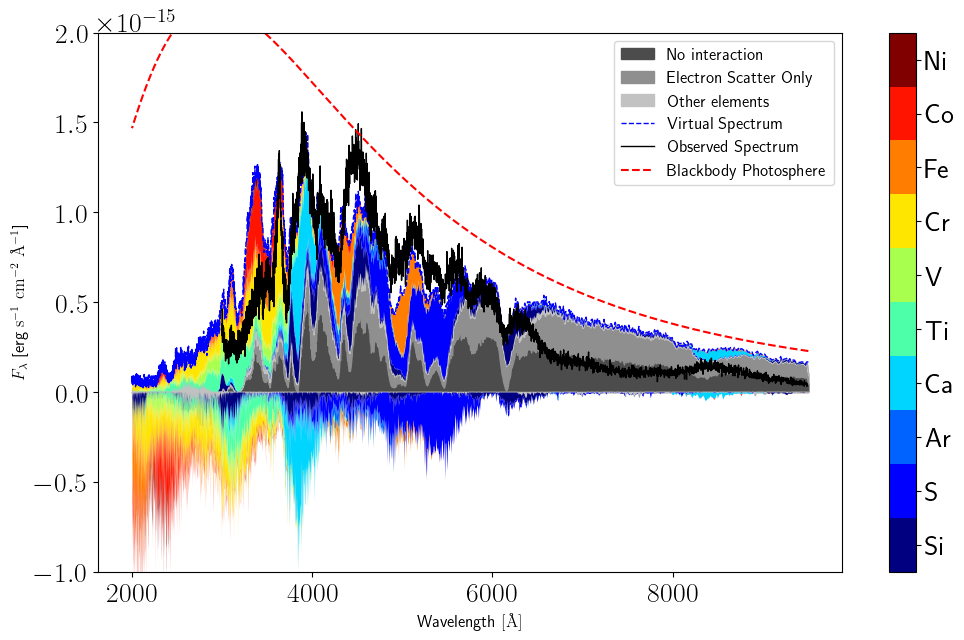

In [10]:
plotter = SDECPlotter.from_simulation(sim)
# 2D SEDONA simulation
syn_dat = np.loadtxt('./Shen+2021/d14e5_mu_0_spec.txt')
plotter.generate_plot_mpl(
    packet_wvl_range=[2000, 9500] * u.AA,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 2.5,
    ),
    distance=114.48 * u.Mpc, nelements=10
)
ax = plt.gca()
ax.set_ylim([-1e-15, 2e-15])
plt.show()

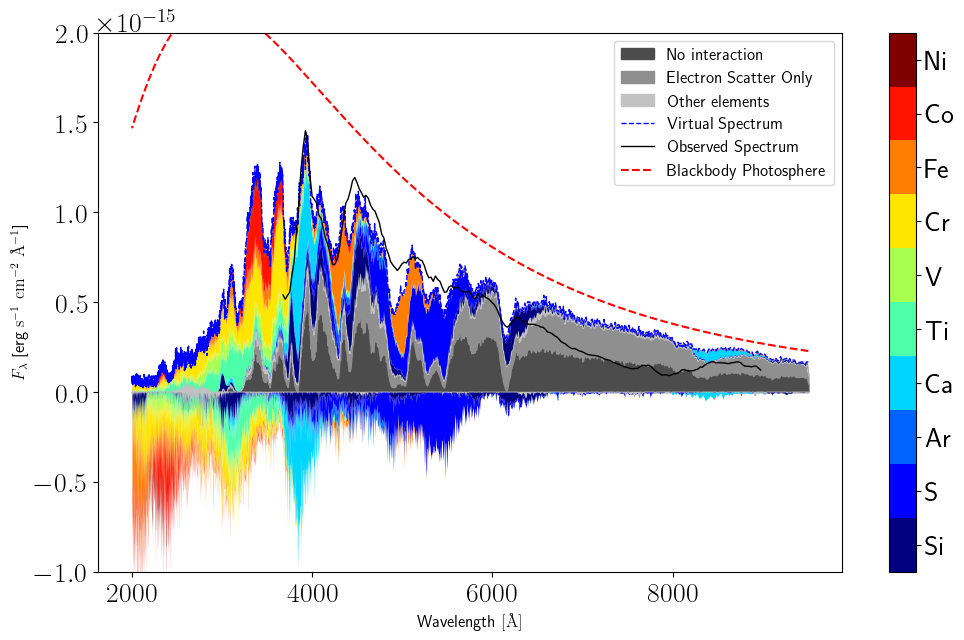

In [11]:
# observation
plotter.generate_plot_mpl(
    packet_wvl_range=[2000, 9500] * u.AA,
    # observed_spectrum=(
    #     syn_dat[:, 0] * u.AA,
    #     syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 2.5,
    # ),
    observed_spectrum=(
        joj2[:, 0] / (1 + z) * u.AA,
        joj2[:, 1] * (1 + z) * u.erg / u.cm**2 / u.s / u.AA / 2.5,
    ),
    distance=114.48 * u.Mpc, nelements=10
)
ax = plt.gca()
ax.set_ylim([-1e-15, 2e-15])
plt.show()

In [12]:
with open('./Shen+2021/d14e5_mu_0_spec.txt') as f:
    l = f.readline()
    time = float(l.split('=')[-1])
    l = f.readline()
    log_L = float(l.split('=')[-1])
write_CSVY('./d14e5_mu00', isotopes=iso_title, profile=profile, time=time, vmin=10000)
write_config(fname='tardis_+2.yml', log_L=log_L, time=time, csvy_model='d14e5_mu00')
sim0 = run_tardis("tardis_+2.yml",
                 virtual_packet_logging=True,
                 show_convergence_plots=True,
                 export_convergence_plots=True,
                 log_level="INFO")
plotter = SDECPlotter.from_simulation(sim0)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning:

invalid value encountered in true_divide

 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 40 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.080e+42 erg / s
	Luminosity absorbed  = 3.409e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.33e+03,9.77e+03,0.39,0.535
5,9.25e+03,9.25e+03,0.19,0.237
10,9.18e+03,8.56e+03,0.123,0.13
15,9.1e+03,7.82e+03,0.0869,0.109
20,9.03e+03,6.5e+03,0.0652,0.134
25,8.96e+03,6.32e+03,0.0509,0.111
30,8.89e+03,6.23e+03,0.0409,0.092
35,8.82e+03,6.16e+03,0.0336,0.0777


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9338.619 K
	Expected t_inner for next iteration = 9962.420 K
 (base.py:554)


    'data': [{'type': 'scatter', 'uid': '5f51dccd-3817-46c0-87dd-952ce0097cf9', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.029e+42 erg / s
	Luminosity absorbed  = 4.397e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.77e+03,1.03e+04,0.535,0.571
5,9.25e+03,9.51e+03,0.237,0.274
10,8.56e+03,9.28e+03,0.13,0.137
15,7.82e+03,8.59e+03,0.109,0.113
20,6.5e+03,6.51e+03,0.134,0.164
25,6.32e+03,6.27e+03,0.111,0.139
30,6.23e+03,6.17e+03,0.092,0.115
35,6.16e+03,6.09e+03,0.0777,0.0979


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9962.420 K
	Expected t_inner for next iteration = 10462.862 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.951e+42 erg / s
	Luminosity absorbed  = 5.002e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.03e+04,1.09e+04,0.571,0.574
5,9.51e+03,9.8e+03,0.274,0.285
10,9.28e+03,9.53e+03,0.137,0.14
15,8.59e+03,8.88e+03,0.113,0.111
20,6.51e+03,6.93e+03,0.164,0.152
25,6.27e+03,6.63e+03,0.139,0.131
30,6.17e+03,6.53e+03,0.115,0.109
35,6.09e+03,6.45e+03,0.0979,0.092


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10462.862 K
	Expected t_inner for next iteration = 10861.507 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 6.945e+42 erg / s
	Luminosity absorbed  = 5.493e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.13e+04,0.574,0.561
5,9.8e+03,1.02e+04,0.285,0.284
10,9.53e+03,9.74e+03,0.14,0.148
15,8.88e+03,9.01e+03,0.111,0.117
20,6.93e+03,7.11e+03,0.152,0.156
25,6.63e+03,6.87e+03,0.131,0.131
30,6.53e+03,6.77e+03,0.109,0.109
35,6.45e+03,6.68e+03,0.092,0.0923


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10861.507 K
	Expected t_inner for next iteration = 11163.914 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.709e+42 erg / s
	Luminosity absorbed  = 5.800e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.13e+04,1.17e+04,0.561,0.551
5,1.02e+04,1.06e+04,0.284,0.28
10,9.74e+03,1.02e+04,0.148,0.145
15,9.01e+03,9.41e+03,0.117,0.114
20,7.11e+03,7.31e+03,0.156,0.155
25,6.87e+03,7.07e+03,0.131,0.129
30,6.77e+03,6.96e+03,0.109,0.107
35,6.68e+03,6.87e+03,0.0923,0.0908


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11163.914 K
	Expected t_inner for next iteration = 11402.166 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.227e+42 erg / s
	Luminosity absorbed  = 6.120e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.17e+04,1.2e+04,0.551,0.547
5,1.06e+04,1.08e+04,0.28,0.28
10,1.02e+04,1.03e+04,0.145,0.148
15,9.41e+03,9.37e+03,0.114,0.121
20,7.31e+03,7.37e+03,0.155,0.161
25,7.07e+03,7.13e+03,0.129,0.134
30,6.96e+03,7.02e+03,0.107,0.111
35,6.87e+03,6.93e+03,0.0908,0.0943


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11402.166 K
	Expected t_inner for next iteration = 11601.236 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.699e+42 erg / s
	Luminosity absorbed  = 6.368e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.2e+04,1.23e+04,0.547,0.529
5,1.08e+04,1.12e+04,0.28,0.264
10,1.03e+04,1.05e+04,0.148,0.147
15,9.37e+03,9.52e+03,0.121,0.123
20,7.37e+03,7.46e+03,0.161,0.162
25,7.13e+03,7.21e+03,0.134,0.137
30,7.02e+03,7.09e+03,0.111,0.113
35,6.93e+03,7e+03,0.0943,0.096


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11601.236 K
	Expected t_inner for next iteration = 11766.264 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.933e+42 erg / s
	Luminosity absorbed  = 6.670e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.23e+04,1.25e+04,0.529,0.53
5,1.12e+04,1.15e+04,0.264,0.258
10,1.05e+04,1.08e+04,0.147,0.144
15,9.52e+03,9.64e+03,0.123,0.121
20,7.46e+03,7.52e+03,0.162,0.161
25,7.21e+03,7.27e+03,0.137,0.135
30,7.09e+03,7.16e+03,0.113,0.112
35,7e+03,7.06e+03,0.096,0.0951


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11766.264 K
	Expected t_inner for next iteration = 11915.955 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.164e+42 erg / s
	Luminosity absorbed  = 6.990e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.25e+04,1.28e+04,0.53,0.517
5,1.15e+04,1.17e+04,0.258,0.255
10,1.08e+04,1.08e+04,0.144,0.141
15,9.64e+03,9.71e+03,0.121,0.121
20,7.52e+03,7.61e+03,0.161,0.158
25,7.27e+03,7.35e+03,0.135,0.133
30,7.16e+03,7.23e+03,0.112,0.11
35,7.06e+03,7.14e+03,0.0951,0.0934


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11915.955 K
	Expected t_inner for next iteration = 12050.505 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.418e+42 erg / s
	Luminosity absorbed  = 7.251e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.28e+04,1.3e+04,0.517,0.51
5,1.17e+04,1.19e+04,0.255,0.248
10,1.08e+04,1.09e+04,0.141,0.142
15,9.71e+03,9.62e+03,0.121,0.125
20,7.61e+03,7.61e+03,0.158,0.162
25,7.35e+03,7.33e+03,0.133,0.138
30,7.23e+03,7.22e+03,0.11,0.114
35,7.14e+03,7.13e+03,0.0934,0.0966


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12050.505 K
	Expected t_inner for next iteration = 12168.337 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.565e+42 erg / s
	Luminosity absorbed  = 7.445e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.3e+04,1.32e+04,0.51,0.506
5,1.19e+04,1.23e+04,0.248,0.236
10,1.09e+04,1.12e+04,0.142,0.14
15,9.62e+03,9.9e+03,0.125,0.119
20,7.61e+03,7.64e+03,0.162,0.163
25,7.33e+03,7.37e+03,0.138,0.138
30,7.22e+03,7.25e+03,0.114,0.114
35,7.13e+03,7.16e+03,0.0966,0.097


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12168.337 K
	Expected t_inner for next iteration = 12277.016 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.730e+42 erg / s
	Luminosity absorbed  = 7.663e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.32e+04,1.34e+04,0.506,0.494
5,1.23e+04,1.25e+04,0.236,0.226
10,1.12e+04,1.12e+04,0.14,0.14
15,9.9e+03,9.83e+03,0.119,0.123
20,7.64e+03,7.63e+03,0.163,0.165
25,7.37e+03,7.38e+03,0.138,0.138
30,7.25e+03,7.27e+03,0.114,0.114
35,7.16e+03,7.18e+03,0.097,0.0966


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12277.016 K
	Expected t_inner for next iteration = 12375.273 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.806e+42 erg / s
	Luminosity absorbed  = 7.982e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.34e+04,1.35e+04,0.494,0.504
5,1.25e+04,1.27e+04,0.226,0.225
10,1.12e+04,1.13e+04,0.14,0.139
15,9.83e+03,9.93e+03,0.123,0.121
20,7.63e+03,7.74e+03,0.165,0.16
25,7.38e+03,7.41e+03,0.138,0.138
30,7.27e+03,7.29e+03,0.114,0.115
35,7.18e+03,7.2e+03,0.0966,0.0974


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12375.273 K
	Expected t_inner for next iteration = 12469.182 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.001e+43 erg / s
	Luminosity absorbed  = 8.192e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.35e+04,1.37e+04,0.504,0.494
5,1.27e+04,1.28e+04,0.225,0.228
10,1.13e+04,1.15e+04,0.139,0.135
15,9.93e+03,1.01e+04,0.121,0.119
20,7.74e+03,7.72e+03,0.16,0.164
25,7.41e+03,7.44e+03,0.138,0.138
30,7.29e+03,7.32e+03,0.115,0.115
35,7.2e+03,7.23e+03,0.0974,0.0974


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12469.182 K
	Expected t_inner for next iteration = 12549.832 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.011e+43 erg / s
	Luminosity absorbed  = 8.357e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.37e+04,1.38e+04,0.494,0.501
5,1.28e+04,1.3e+04,0.228,0.222
10,1.15e+04,1.18e+04,0.135,0.13
15,1.01e+04,1.02e+04,0.119,0.115
20,7.72e+03,7.82e+03,0.164,0.158
25,7.44e+03,7.53e+03,0.138,0.134
30,7.32e+03,7.41e+03,0.115,0.111
35,7.23e+03,7.32e+03,0.0974,0.094


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12549.832 K
	Expected t_inner for next iteration = 12624.808 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.008e+43 erg / s
	Luminosity absorbed  = 8.593e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.38e+04,1.39e+04,0.501,0.497
5,1.3e+04,1.31e+04,0.222,0.217
10,1.18e+04,1.21e+04,0.13,0.122
15,1.02e+04,1.02e+04,0.115,0.114
20,7.82e+03,7.85e+03,0.158,0.156
25,7.53e+03,7.57e+03,0.134,0.131
30,7.41e+03,7.44e+03,0.111,0.109
35,7.32e+03,7.35e+03,0.094,0.0922


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12624.808 K
	Expected t_inner for next iteration = 12701.905 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.015e+43 erg / s
	Luminosity absorbed  = 8.720e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.39e+04,1.4e+04,0.497,0.496
5,1.31e+04,1.34e+04,0.217,0.213
10,1.21e+04,1.22e+04,0.122,0.122
15,1.02e+04,1.04e+04,0.114,0.111
20,7.85e+03,7.91e+03,0.156,0.155
25,7.57e+03,7.59e+03,0.131,0.132
30,7.44e+03,7.47e+03,0.109,0.11
35,7.35e+03,7.37e+03,0.0922,0.0929


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12701.905 K
	Expected t_inner for next iteration = 12774.785 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.033e+43 erg / s
	Luminosity absorbed  = 8.828e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.4e+04,1.41e+04,0.496,0.496
5,1.34e+04,1.37e+04,0.213,0.208
10,1.22e+04,1.24e+04,0.122,0.117
15,1.04e+04,1.05e+04,0.111,0.111
20,7.91e+03,7.96e+03,0.155,0.155
25,7.59e+03,7.66e+03,0.132,0.131
30,7.47e+03,7.53e+03,0.11,0.109
35,7.37e+03,7.43e+03,0.0929,0.092


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12774.785 K
	Expected t_inner for next iteration = 12836.601 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.051e+43 erg / s
	Luminosity absorbed  = 8.777e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.41e+04,1.42e+04,0.496,0.498
5,1.37e+04,1.4e+04,0.208,0.205
10,1.24e+04,1.29e+04,0.117,0.111
15,1.05e+04,1.08e+04,0.111,0.106
20,7.96e+03,8e+03,0.155,0.155
25,7.66e+03,7.7e+03,0.131,0.131
30,7.53e+03,7.58e+03,0.109,0.108
35,7.43e+03,7.48e+03,0.092,0.0915


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12836.601 K
	Expected t_inner for next iteration = 12886.862 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 8.912e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.42e+04,1.42e+04,0.498,0.499
5,1.4e+04,1.41e+04,0.205,0.206
10,1.29e+04,1.32e+04,0.111,0.107
15,1.08e+04,1.1e+04,0.106,0.103
20,8e+03,8.14e+03,0.155,0.148
25,7.7e+03,7.83e+03,0.131,0.125
30,7.58e+03,7.7e+03,0.108,0.104
35,7.48e+03,7.6e+03,0.0915,0.088


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12886.862 K
	Expected t_inner for next iteration = 12929.884 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 21 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.064e+43 erg / s
	Luminosity absorbed  = 8.999e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.42e+04,1.43e+04,0.499,0.493
5,1.41e+04,1.41e+04,0.206,0.197
10,1.32e+04,1.32e+04,0.107,0.104
15,1.1e+04,1.13e+04,0.103,0.0945
20,8.14e+03,8.23e+03,0.148,0.143
25,7.83e+03,7.92e+03,0.125,0.12
30,7.7e+03,7.79e+03,0.104,0.0992
35,7.6e+03,7.69e+03,0.088,0.0839


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12929.884 K
	Expected t_inner for next iteration = 12972.526 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 22 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.077e+43 erg / s
	Luminosity absorbed  = 8.836e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.43e+04,1.44e+04,0.493,0.487
5,1.41e+04,1.41e+04,0.197,0.203
10,1.32e+04,1.34e+04,0.104,0.101
15,1.13e+04,1.15e+04,0.0945,0.0931
20,8.23e+03,8.39e+03,0.143,0.136
25,7.92e+03,8.02e+03,0.12,0.117
30,7.79e+03,7.89e+03,0.0992,0.0971
35,7.69e+03,7.78e+03,0.0839,0.0822


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12972.526 K
	Expected t_inner for next iteration = 13007.255 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 23 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 9.150e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.43e+04,0.487,0.503
5,1.41e+04,1.41e+04,0.203,0.203
10,1.34e+04,1.37e+04,0.101,0.0952
15,1.15e+04,1.18e+04,0.0931,0.0857
20,8.39e+03,8.53e+03,0.136,0.129
25,8.02e+03,8.1e+03,0.117,0.113
30,7.89e+03,7.96e+03,0.0971,0.0936
35,7.78e+03,7.86e+03,0.0822,0.0792


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13007.255 K
	Expected t_inner for next iteration = 13051.955 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 24 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.090e+43 erg / s
	Luminosity absorbed  = 9.228e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.43e+04,1.44e+04,0.503,0.505
5,1.41e+04,1.4e+04,0.203,0.205
10,1.37e+04,1.38e+04,0.0952,0.0928
15,1.18e+04,1.19e+04,0.0857,0.0856
20,8.53e+03,8.53e+03,0.129,0.133
25,8.1e+03,8.11e+03,0.113,0.115
30,7.96e+03,7.97e+03,0.0936,0.0955
35,7.86e+03,7.87e+03,0.0792,0.0808


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13051.955 K
	Expected t_inner for next iteration = 13078.567 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 25 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.072e+43 erg / s
	Luminosity absorbed  = 9.165e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.44e+04,0.505,0.493
5,1.4e+04,1.39e+04,0.205,0.206
10,1.38e+04,1.35e+04,0.0928,0.0956
15,1.19e+04,1.19e+04,0.0856,0.0841
20,8.53e+03,8.5e+03,0.133,0.134
25,8.11e+03,8.09e+03,0.115,0.116
30,7.97e+03,7.95e+03,0.0955,0.096
35,7.87e+03,7.84e+03,0.0808,0.0813


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13078.567 K
	Expected t_inner for next iteration = 13116.588 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 26 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.112e+43 erg / s
	Luminosity absorbed  = 9.506e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.44e+04,0.493,0.499
5,1.39e+04,1.39e+04,0.206,0.214
10,1.35e+04,1.33e+04,0.0956,0.102
15,1.19e+04,1.17e+04,0.0841,0.0896
20,8.5e+03,8.4e+03,0.134,0.141
25,8.09e+03,8.02e+03,0.116,0.121
30,7.95e+03,7.89e+03,0.096,0.101
35,7.84e+03,7.78e+03,0.0813,0.0852


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13116.588 K
	Expected t_inner for next iteration = 13130.304 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 27 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.110e+43 erg / s
	Luminosity absorbed  = 9.288e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.45e+04,0.499,0.493
5,1.39e+04,1.41e+04,0.214,0.21
10,1.33e+04,1.34e+04,0.102,0.104
15,1.17e+04,1.16e+04,0.0896,0.0907
20,8.4e+03,8.36e+03,0.141,0.144
25,8.02e+03,7.99e+03,0.121,0.123
30,7.89e+03,7.86e+03,0.101,0.102
35,7.78e+03,7.76e+03,0.0852,0.0865


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13130.304 K
	Expected t_inner for next iteration = 13145.229 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 28 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.138e+43 erg / s
	Luminosity absorbed  = 9.302e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.44e+04,0.493,0.507
5,1.41e+04,1.41e+04,0.21,0.207
10,1.34e+04,1.33e+04,0.104,0.105
15,1.16e+04,1.16e+04,0.0907,0.0924
20,8.36e+03,8.38e+03,0.144,0.144
25,7.99e+03,8.04e+03,0.123,0.122
30,7.86e+03,7.91e+03,0.102,0.101
35,7.76e+03,7.81e+03,0.0865,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13145.229 K
	Expected t_inner for next iteration = 13143.441 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 29 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.121e+43 erg / s
	Luminosity absorbed  = 9.254e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.44e+04,0.507,0.503
5,1.41e+04,1.4e+04,0.207,0.211
10,1.33e+04,1.33e+04,0.105,0.103
15,1.16e+04,1.17e+04,0.0924,0.0911
20,8.38e+03,8.38e+03,0.144,0.143
25,8.04e+03,8.05e+03,0.122,0.121
30,7.91e+03,7.92e+03,0.101,0.1
35,7.81e+03,7.82e+03,0.0858,0.0846


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13143.441 K
	Expected t_inner for next iteration = 13151.798 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 30 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.119e+43 erg / s
	Luminosity absorbed  = 9.354e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.45e+04,0.503,0.498
5,1.4e+04,1.4e+04,0.211,0.21
10,1.33e+04,1.34e+04,0.103,0.102
15,1.17e+04,1.18e+04,0.0911,0.0878
20,8.38e+03,8.46e+03,0.143,0.138
25,8.05e+03,8.07e+03,0.121,0.119
30,7.92e+03,7.93e+03,0.1,0.0989
35,7.82e+03,7.83e+03,0.0846,0.0837


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13151.798 K
	Expected t_inner for next iteration = 13160.939 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 31 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.130e+43 erg / s
	Luminosity absorbed  = 9.207e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.44e+04,0.498,0.503
5,1.4e+04,1.41e+04,0.21,0.213
10,1.34e+04,1.33e+04,0.102,0.106
15,1.18e+04,1.17e+04,0.0878,0.0912
20,8.46e+03,8.39e+03,0.138,0.144
25,8.07e+03,8.05e+03,0.119,0.122
30,7.93e+03,7.92e+03,0.0989,0.101
35,7.83e+03,7.81e+03,0.0837,0.0856


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13160.939 K
	Expected t_inner for next iteration = 13163.933 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 32 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.136e+43 erg / s
	Luminosity absorbed  = 9.311e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.45e+04,0.503,0.5
5,1.41e+04,1.42e+04,0.213,0.21
10,1.33e+04,1.35e+04,0.106,0.104
15,1.17e+04,1.18e+04,0.0912,0.0893
20,8.39e+03,8.4e+03,0.144,0.143
25,8.05e+03,8.06e+03,0.122,0.121
30,7.92e+03,7.93e+03,0.101,0.1
35,7.81e+03,7.83e+03,0.0856,0.0846


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13163.933 K
	Expected t_inner for next iteration = 13163.106 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 33 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.129e+43 erg / s
	Luminosity absorbed  = 9.342e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.5,0.497
5,1.42e+04,1.42e+04,0.21,0.206
10,1.35e+04,1.36e+04,0.104,0.0998
15,1.18e+04,1.18e+04,0.0893,0.0888
20,8.4e+03,8.42e+03,0.143,0.141
25,8.06e+03,8.08e+03,0.121,0.12
30,7.93e+03,7.94e+03,0.1,0.0992
35,7.83e+03,7.84e+03,0.0846,0.0839


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13163.106 K
	Expected t_inner for next iteration = 13166.650 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 34 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.119e+43 erg / s
	Luminosity absorbed  = 9.268e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.497,0.498
5,1.42e+04,1.43e+04,0.206,0.2
10,1.36e+04,1.36e+04,0.0998,0.0981
15,1.18e+04,1.18e+04,0.0888,0.0879
20,8.42e+03,8.52e+03,0.141,0.136
25,8.08e+03,8.14e+03,0.12,0.117
30,7.94e+03,8.01e+03,0.0992,0.0967
35,7.84e+03,7.9e+03,0.0839,0.0819


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13166.650 K
	Expected t_inner for next iteration = 13176.013 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 35 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.109e+43 erg / s
	Luminosity absorbed  = 9.438e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.498,0.508
5,1.43e+04,1.42e+04,0.2,0.204
10,1.36e+04,1.38e+04,0.0981,0.0955
15,1.18e+04,1.2e+04,0.0879,0.0848
20,8.52e+03,8.45e+03,0.136,0.139
25,8.14e+03,8.11e+03,0.117,0.117
30,8.01e+03,7.98e+03,0.0967,0.097
35,7.9e+03,7.88e+03,0.0819,0.082


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13176.013 K
	Expected t_inner for next iteration = 13191.650 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 36 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.135e+43 erg / s
	Luminosity absorbed  = 9.536e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.44e+04,0.508,0.513
5,1.42e+04,1.42e+04,0.204,0.206
10,1.38e+04,1.38e+04,0.0955,0.0948
15,1.2e+04,1.2e+04,0.0848,0.0872
20,8.45e+03,8.54e+03,0.139,0.138
25,8.11e+03,8.17e+03,0.117,0.118
30,7.98e+03,8.01e+03,0.097,0.0986
35,7.88e+03,7.9e+03,0.082,0.0834


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13191.650 K
	Expected t_inner for next iteration = 13191.639 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 37 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.119e+43 erg / s
	Luminosity absorbed  = 9.489e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.45e+04,0.513,0.505
5,1.42e+04,1.42e+04,0.206,0.206
10,1.38e+04,1.37e+04,0.0948,0.0956
15,1.2e+04,1.19e+04,0.0872,0.0868
20,8.54e+03,8.59e+03,0.138,0.133
25,8.17e+03,8.17e+03,0.118,0.115
30,8.01e+03,8.04e+03,0.0986,0.0957
35,7.9e+03,7.93e+03,0.0834,0.0809


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13191.639 K
	Expected t_inner for next iteration = 13201.178 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 38 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.134e+43 erg / s
	Luminosity absorbed  = 9.417e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.505,0.504
5,1.42e+04,1.42e+04,0.206,0.205
10,1.37e+04,1.37e+04,0.0956,0.0961
15,1.19e+04,1.21e+04,0.0868,0.0856
20,8.59e+03,8.54e+03,0.133,0.136
25,8.17e+03,8.16e+03,0.115,0.116
30,8.04e+03,8.02e+03,0.0957,0.0968
35,7.93e+03,7.91e+03,0.0809,0.0819


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13201.178 K
	Expected t_inner for next iteration = 13201.949 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 39 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.128e+43 erg / s
	Luminosity absorbed  = 9.593e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.504,0.505
5,1.42e+04,1.42e+04,0.205,0.203
10,1.37e+04,1.36e+04,0.0961,0.096
15,1.21e+04,1.19e+04,0.0856,0.0844
20,8.54e+03,8.57e+03,0.136,0.134
25,8.16e+03,8.18e+03,0.116,0.115
30,8.02e+03,8.05e+03,0.0968,0.0949
35,7.91e+03,7.93e+03,0.0819,0.0807


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13201.949 K
	Expected t_inner for next iteration = 13205.822 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 40 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.129e+43 erg / s
	Luminosity absorbed  = 9.516e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 40 iterations 
	Simulation took 490.38 s
 (base.py:480)


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:1247: AstropyDeprecationWarning:

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.

 (warnings.py:109)


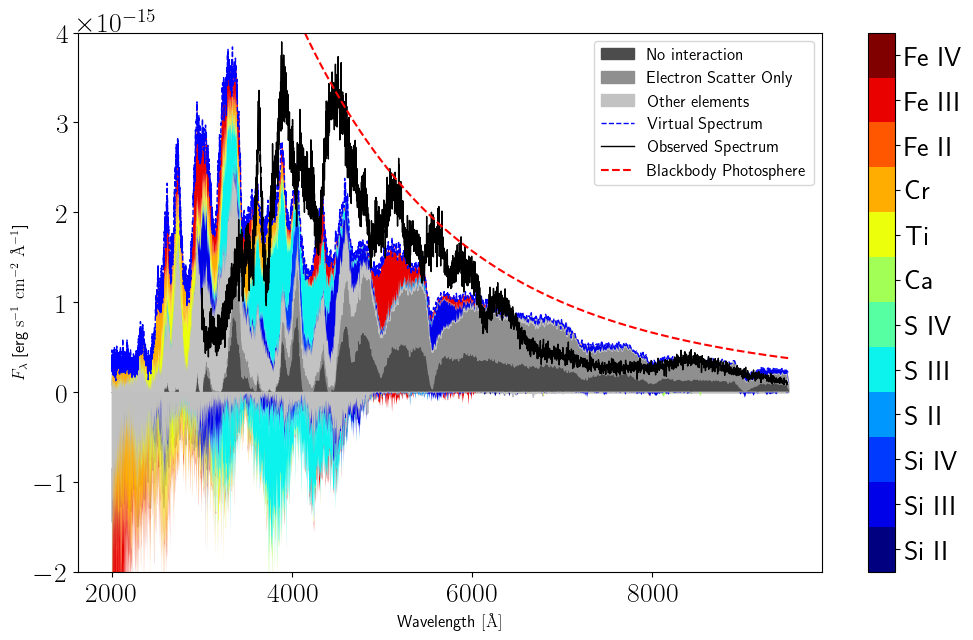

In [17]:
# 2D SEDONA simulation
syn_dat = np.loadtxt('./Shen+2021/d14e5_mu_0_spec.txt')
plotter.generate_plot_mpl(
    packet_wvl_range=[2000, 9500] * u.AA,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA,
    ),
    distance=114.48 * u.Mpc, species_list = ['Si II-IV', 'S II-IV', 'Fe II-IV', 'Ca', 'Ti', 'Cr']
)
ax = plt.gca()
ax.set_ylim([-2e-15, 4e-15])
plt.show()